<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
t_save=np.array(t_save) # convert t_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-12-19 10:52:57,783 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:__main__:Starting main loop


2024-12-19 10:52:57,794 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-19 10:52:58,186 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2024-12-19 10:52:58,198 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2024-12-19 10:52:58,205 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.307 sec


2024-12-19 10:52:58,212 solvers 0/1 INFO :: Setup time (init - iter 0): 0.307 sec


INFO:solvers:Warmup time (iter 0-10): 0.118 sec


2024-12-19 10:52:58,218 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.118 sec


INFO:solvers:Run time (iter 10-end): 0.2808 sec


2024-12-19 10:52:58,225 solvers 0/1 INFO :: Run time (iter 10-end): 0.2808 sec


INFO:solvers:CPU time (iter 10-end): 7.8e-05 cpu-hr


2024-12-19 10:52:58,238 solvers 0/1 INFO :: CPU time (iter 10-end): 7.8e-05 cpu-hr


INFO:solvers:Speed: 6.551e+05 mode-stages/cpu-sec


2024-12-19 10:52:58,245 solvers 0/1 INFO :: Speed: 6.551e+05 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 10:52:58,444 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5ictu9by/temp.m4v


2024-12-19 10:52:58,450 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5ictu9by/temp.m4v


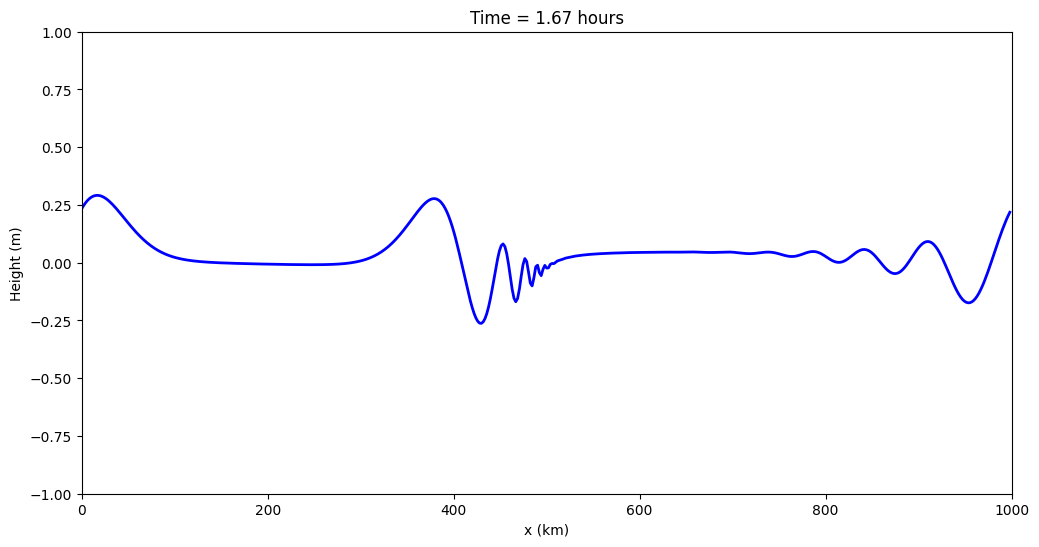

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

Consider a compressible gas. We have conservation of mass, which in 1D becomes
$$ \frac{\partial \rho}{\partial t} + u \frac{\partial \rho}{\partial x} + \rho\frac{\partial u}{\partial x} = 0\, .$$

We also have conservation of momentum, which in 1D is
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = -\frac{1}{\rho}\frac{\partial p}{\partial x}\, . $$

Assuming homentropic flow of an ideal gas, the sound speed is given by
$$ c^2(\rho) = \frac{\partial p}{\partial \rho}(\rho)\, .$$

Hence, conservation of momentum can be expressed as
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} +\frac{c^2}{\rho}\frac{\partial \rho}{\partial x} = 0\, . $$

Now, consider the 1D shallow water equations, which can be written in the form:
$$ \frac{\partial h}{\partial t} + u \frac{\partial(H+h)}{\partial x} + (H+h)\frac{\partial u}{\partial x} = 0\, ,$$
and
$$ \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + g\frac{\partial h}{\partial x} = 0\, .$$

Now, assuming $\frac{\partial H}{\partial t} = 0$ and $\frac{\partial H}{\partial x} << 1$, the 1D shallow water equations have exactly the same form as the equations for 1D flow in a perfect compressible flow. We identify $(H+h, u, g)$ in shallow water with $(\rho, u, \frac{c^2}{\rho})$ in a perfect gas. Therefore, the "sound speed" in the shallow water equations is
$$ c = \sqrt{g(H+h)}\, .$$

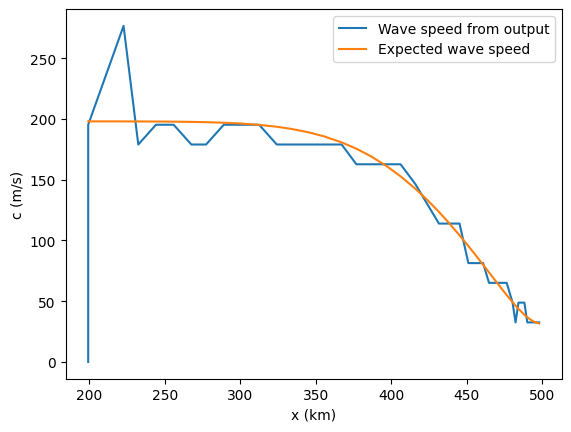

In [ ]:
# CREATE FIGURES HERE

# Resting water depth
Hg = H['g']

# Peak position of the right moving wave
x_index_min = np.argmin(np.abs(x - x1))
peak_position = np.zeros(len(t_save))
peak_height = np.zeros(len(t_save))
resting_depth_at_peak_position = np.zeros(len(t_save))
for i in range(len(t_save)):
  peak_index = np.argmax(h_save[i,x_index_min:])
  peak_position[i] = x[peak_index+x_index_min]
  peak_height[i] = h_save[i,peak_index+x_index_min]
  resting_depth_at_peak_position[i] = Hg[peak_index+x_index_min]

end_time = np.argmin(np.abs(peak_position - x2))
time = t_save[0:end_time]
peak_position = peak_position[0:end_time]
peak_height = peak_height[0:end_time]
resting_depth_at_peak_position = resting_depth_at_peak_position[0:end_time]

# Output wave speed
c_output = np.zeros(len(time))
c_output[0] = (peak_position[1]-peak_position[0])/timestep # forward difference
c_output[-1] = (peak_position[-1]-peak_position[-2])/timestep # forward difference
for i in range(len(time)-2):
  c_output[i+1] = (peak_position[i+2] - peak_position[i])/(2*timestep) # Central difference


# Expected wave speed
c_expected = np.zeros(len(time))
for i in range(len(time)):
  c_expected[i] = np.sqrt(g*(resting_depth_at_peak_position[i]+peak_height[i]))

plt.plot(peak_position/(1*kilometer), c_output)
plt.plot(peak_position/(1*kilometer), c_expected)
plt.xlabel('x (km)')
plt.ylabel('c (m/s)')
plt.legend(['Wave speed from output','Expected wave speed'])


COMMENT ON RESULTS

The figure above shows a plot of the expected wave speed of the tsunami from the initial disturbance until it reaches the peak of the seamount. We also plot the wave speed from the output of the dedalus script. To do this, we notice from the movie that the tsunami is the highest peak until reaching the seamount, allowing us to identify its postion at each time interval. We use the forward difference
$$ c_{\mathrm{output}} = \frac{x_{\mathrm{peak}}(t+\Delta t) - x_{\mathrm{peak}}(t)}{\Delta t}\, ,$$
for the first and final time steps. We use the central difference
$$ c_{\mathrm{output}} = \frac{x_{\mathrm{peak}}(t+\Delta t) - x_{\mathrm{peak}}(t-\Delta t)}{2\Delta t}\, ,$$
for the intermediate time steps.

From the figure, we see that once the initial disturbance produces a right propagating wave, there is good agreement with the observed wave speed and the expected wave speed. As the tsunami approaches the seamount and the resting water depth decreases, the wave speed decreases. However, the wave speed from the output is not as smooth as the expected wave speed, which is a result of the discrete grid in $x$ only allowing discrete wave speeds for the constant time step.

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
t_save=np.array(t_save)

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 2.6e+01/s


2024-12-19 20:21:53,846 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2024-12-19 20:21:53,917 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


2024-12-19 20:21:53,999 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.2e+01/s


2024-12-19 20:21:54,180 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.2e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s


2024-12-19 20:21:54,274 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.5e+01/s


2024-12-19 20:21:54,383 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.2e+01/s


2024-12-19 20:21:54,557 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.2e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.0e+01/s


2024-12-19 20:21:54,745 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.0e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.9e+01/s


2024-12-19 20:21:54,912 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.9e+01/s


INFO:__main__:Starting main loop


2024-12-19 20:21:54,924 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-19 20:21:57,472 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-12-19 20:21:57,480 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-12-19 20:21:57,487 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 1.929 sec


2024-12-19 20:21:57,494 solvers 0/1 INFO :: Setup time (init - iter 0): 1.929 sec


INFO:solvers:Warmup time (iter 0-10): 1.143 sec


2024-12-19 20:21:57,508 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.143 sec


INFO:solvers:Run time (iter 10-end): 0.652 sec


2024-12-19 20:21:57,526 solvers 0/1 INFO :: Run time (iter 10-end): 0.652 sec


INFO:solvers:CPU time (iter 10-end): 0.0001811 cpu-hr


2024-12-19 20:21:57,531 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0001811 cpu-hr


INFO:solvers:Speed: 7.305e+05 mode-stages/cpu-sec


2024-12-19 20:21:57,547 solvers 0/1 INFO :: Speed: 7.305e+05 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 20:21:57,884 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpb51cdf_z/temp.m4v


2024-12-19 20:21:57,895 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpb51cdf_z/temp.m4v


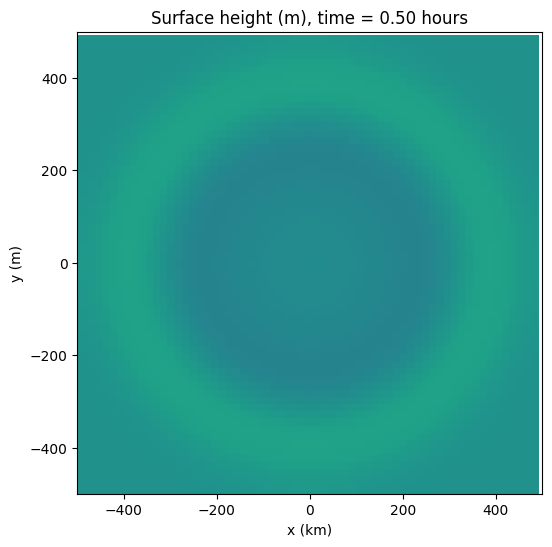

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation.

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

ADD PREDICTION OF WAVE AMPLITUDE HERE (a few sentences and/or equations)

Both the potential and kinetic energy densities are proportional to the square of the wave amplitude. Hence, the total energy (which is conserved) is proportional to the radial distance times the wave amplitude
$$ E \propto rh^2\, . $$
Therefore, we expect the wave amplitude to vary like
$$ h \propto r^{-1/2}\, . $$

The code block below produces a plot of the wave amplitude as a function of the radial distance from the origin. Note that since the initial Gaussian disturbance produces an axisymmetric wave, we can reduce the problem to 1D, and simply plot the wave amplitude as a function of $x > 0$ for $y = 0$. We see that initially the peak is localised at the origin, but then produces a wave which propagates outwards.

To test our predicted power law relationship, we produce a log-log plot of wave amplitude against radial distance (for the positive values of $r$) and perfom a linear regression. The output matches well with out prediction, since the linear fit has a gradient of $-0.47 \approx -0.5$.

<ipython-input-126-144fccc74046>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  peak_position[i] = r[peak_index]


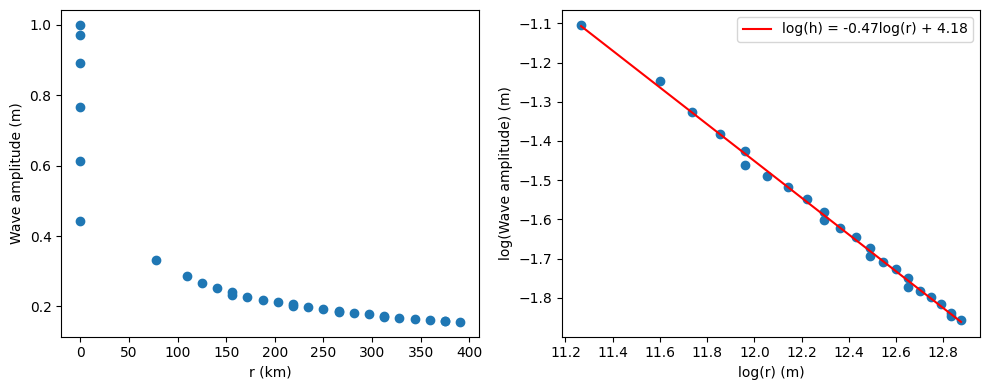

In [ ]:
# ADD CODE TO MAKE PLOTS HERE

# radial symmetry so find h(r) with y=0 and x>0
y_index = np.argmin(np.abs(y))
x_min_index = np.argmin(np.abs(x))
h_r = h_save[:,x_min_index:,y_index]
r = x[x_min_index:]

peak_position = np.zeros(len(t_save))
peak_height = np.zeros(len(t_save))
for i in range(len(t_save)):
  peak_index = np.argmax(h_r[i,:])
  peak_position[i] = r[peak_index]
  peak_height[i] = h_r[i,peak_index]

fig, ax = plt.subplots(1,2,figsize = (10,4))
ax[0].scatter(peak_position/(1*kilometer),peak_height)
ax[0].set_xlabel('r (km)')
ax[0].set_ylabel('Wave amplitude (m)')

pos_indices = peak_position > 0
peak_position_pos = peak_position[pos_indices]
peak_height_pos = peak_height[pos_indices]
log_peak_position_pos = np.log(peak_position_pos)
log_peak_height_pos = np.log(peak_height_pos)
slope, intercept = np.polyfit(log_peak_position_pos, log_peak_height_pos, 1)
regression_line = slope * log_peak_position_pos + intercept

ax[1].scatter(log_peak_position_pos,log_peak_height_pos)
ax[1].plot(log_peak_position_pos,regression_line, color='r', label=f'log(h) = {slope:.2f}log(r) + {intercept:.2f}')
ax[1].set_xlabel('log(r) (m)')
ax[1].set_ylabel('log(Wave amplitude) (m)')
ax[1].legend()

fig.tight_layout()

ADD DISCUSSION HERE (~1 paragraph)

We can consider diferent forms of the intial condition for the surface height $h$. For example, a sinusoidal intial condition
$$ h = \sin(x/(100\times\mathrm{kilometer}))\, .$$
The code block below solves the shallow water equations with this sinusoidal inititial condition and plots $h$ as a function of $x$ (the disturbance is uniform in the $y$ direction for all time) for various times. We see oscillations of the sine wave with noise from the boundaries affecting the late time structure of the wave.

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


2024-12-19 16:57:08,087 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


2024-12-19 16:57:08,136 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


2024-12-19 16:57:08,191 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


2024-12-19 16:57:08,258 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-12-19 16:57:08,316 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


2024-12-19 16:57:08,385 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-12-19 16:57:08,439 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-12-19 16:57:08,500 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-12-19 16:57:08,563 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:__main__:Starting main loop


2024-12-19 16:57:08,574 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-19 16:57:09,166 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-12-19 16:57:09,172 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-12-19 16:57:09,177 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.5423 sec


2024-12-19 16:57:09,180 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5423 sec


INFO:solvers:Warmup time (iter 0-10): 0.2864 sec


2024-12-19 16:57:09,183 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2864 sec


INFO:solvers:Run time (iter 10-end): 0.3008 sec


2024-12-19 16:57:09,186 solvers 0/1 INFO :: Run time (iter 10-end): 0.3008 sec


INFO:solvers:CPU time (iter 10-end): 8.355e-05 cpu-hr


2024-12-19 16:57:09,188 solvers 0/1 INFO :: CPU time (iter 10-end): 8.355e-05 cpu-hr


INFO:solvers:Speed: 1.583e+06 mode-stages/cpu-sec


2024-12-19 16:57:09,191 solvers 0/1 INFO :: Speed: 1.583e+06 mode-stages/cpu-sec


Text(0, 0.5, 'h (m)')

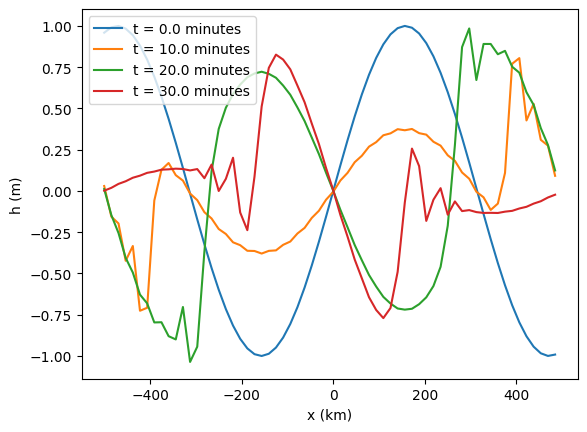

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.sin(x/(100*kilometer))  # Initialize the dependent variable c with a sin function
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
t_save=np.array(t_save)

h_x = h_save[:,:,0];

sample_times = [0, 10, 20, 30] # in minutes
for i in range(len(sample_times)):
  t_index = np.argmin(np.abs(t_save/(1*minute) - sample_times[i]))
  check_t = t_save[t_index]/(1*minute)
  plt.plot(x/(1*kilometer),h_x[t_index,:], label = f't = {check_t} minutes')
plt.legend()
plt.xlabel('x (km)')
plt.ylabel('h (m)')

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way.

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)
t_save = np.array(t_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 2.3e+01/s


2024-12-19 20:22:27,831 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.2e+01/s


2024-12-19 20:22:28,005 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.2e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 2s, Rate: 3.2e+01/s


2024-12-19 20:22:28,232 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 2s, Rate: 3.2e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s


2024-12-19 20:22:28,417 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.4e+01/s


2024-12-19 20:22:28,600 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2024-12-19 20:22:28,800 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.4e+01/s


2024-12-19 20:22:29,025 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.4e+01/s


2024-12-19 20:22:29,210 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 3.5e+01/s


2024-12-19 20:22:29,398 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.5e+01/s


2024-12-19 20:22:29,610 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.5e+01/s


INFO:__main__:Starting main loop


2024-12-19 20:22:29,618 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2024-12-19 20:22:33,814 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2024-12-19 20:22:34,684 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2024-12-19 20:22:35,230 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2024-12-19 20:22:35,904 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2024-12-19 20:22:36,690 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2024-12-19 20:22:37,563 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2024-12-19 20:22:38,527 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2024-12-19 20:22:39,351 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2024-12-19 20:22:39,911 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2024-12-19 20:22:40,443 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2024-12-19 20:22:40,985 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2024-12-19 20:22:41,538 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2024-12-19 20:22:42,076 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2024-12-19 20:22:42,619 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2024-12-19 20:22:43,157 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2024-12-19 20:22:43,683 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2024-12-19 20:22:44,220 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2024-12-19 20:22:44,759 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2024-12-19 20:22:45,302 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2024-12-19 20:22:45,907 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2024-12-19 20:22:46,436 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2024-12-19 20:22:46,971 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2024-12-19 20:22:47,499 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2024-12-19 20:22:48,037 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2024-12-19 20:22:48,577 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2024-12-19 20:22:49,132 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2024-12-19 20:22:49,884 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2024-12-19 20:22:50,741 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2024-12-19 20:22:51,551 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2024-12-19 20:22:52,398 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2024-12-19 20:22:53,123 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2024-12-19 20:22:53,930 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2024-12-19 20:22:55,273 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2024-12-19 20:22:56,433 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2024-12-19 20:22:57,434 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2024-12-19 20:22:58,000 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2024-12-19 20:22:58,542 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2024-12-19 20:22:59,083 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2024-12-19 20:22:59,660 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2024-12-19 20:23:00,201 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2024-12-19 20:23:00,760 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2024-12-19 20:23:01,287 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2024-12-19 20:23:01,823 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2024-12-19 20:23:02,369 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2024-12-19 20:23:02,922 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2024-12-19 20:23:03,811 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2024-12-19 20:23:04,604 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2024-12-19 20:23:05,460 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2024-12-19 20:23:06,348 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2024-12-19 20:23:06,894 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2024-12-19 20:23:07,459 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2024-12-19 20:23:08,060 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2024-12-19 20:23:08,583 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2024-12-19 20:23:09,127 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2024-12-19 20:23:09,685 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2024-12-19 20:23:10,265 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2024-12-19 20:23:10,844 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2024-12-19 20:23:11,389 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2024-12-19 20:23:11,929 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2024-12-19 20:23:12,518 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2024-12-19 20:23:13,108 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2024-12-19 20:23:13,627 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2024-12-19 20:23:14,160 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2024-12-19 20:23:14,685 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2024-12-19 20:23:15,244 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2024-12-19 20:23:15,752 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2024-12-19 20:23:16,292 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2024-12-19 20:23:17,081 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2024-12-19 20:23:17,904 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2024-12-19 20:23:18,720 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2024-12-19 20:23:19,587 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2024-12-19 20:23:20,280 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2024-12-19 20:23:20,816 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2024-12-19 20:23:21,364 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2024-12-19 20:23:21,889 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2024-12-19 20:23:22,421 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2024-12-19 20:23:22,953 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2024-12-19 20:23:23,493 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2024-12-19 20:23:24,013 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2024-12-19 20:23:24,548 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2024-12-19 20:23:25,093 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2024-12-19 20:23:25,629 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2024-12-19 20:23:26,170 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2024-12-19 20:23:26,702 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2024-12-19 20:23:27,259 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2024-12-19 20:23:27,805 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2024-12-19 20:23:28,341 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2024-12-19 20:23:28,946 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2024-12-19 20:23:29,484 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2024-12-19 20:23:30,005 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2024-12-19 20:23:30,823 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2024-12-19 20:23:31,620 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2024-12-19 20:23:32,464 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2024-12-19 20:23:33,313 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2024-12-19 20:23:34,001 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2024-12-19 20:23:34,522 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2024-12-19 20:23:35,064 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2024-12-19 20:23:35,599 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2024-12-19 20:23:36,155 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2024-12-19 20:23:36,676 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2024-12-19 20:23:37,251 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2024-12-19 20:23:37,816 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2024-12-19 20:23:38,342 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2024-12-19 20:23:38,949 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2024-12-19 20:23:39,488 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2024-12-19 20:23:40,046 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2024-12-19 20:23:40,622 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2024-12-19 20:23:41,192 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2024-12-19 20:23:41,715 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2024-12-19 20:23:42,261 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2024-12-19 20:23:42,787 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2024-12-19 20:23:43,333 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2024-12-19 20:23:43,890 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2024-12-19 20:23:44,824 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2024-12-19 20:23:45,594 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2024-12-19 20:23:46,443 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2024-12-19 20:23:47,283 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2024-12-19 20:23:47,858 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2024-12-19 20:23:48,409 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2024-12-19 20:23:48,945 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2024-12-19 20:23:49,526 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2024-12-19 20:23:50,072 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2024-12-19 20:23:50,616 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2024-12-19 20:23:51,343 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2024-12-19 20:23:51,965 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2024-12-19 20:23:52,506 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2024-12-19 20:23:53,043 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2024-12-19 20:23:53,628 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2024-12-19 20:23:54,184 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2024-12-19 20:23:54,713 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2024-12-19 20:23:55,266 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2024-12-19 20:23:55,790 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2024-12-19 20:23:56,308 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2024-12-19 20:23:56,834 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2024-12-19 20:23:57,378 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2024-12-19 20:23:58,172 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2024-12-19 20:23:58,974 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2024-12-19 20:23:59,804 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2024-12-19 20:24:00,634 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2024-12-19 20:24:01,400 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2024-12-19 20:24:01,957 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2024-12-19 20:24:02,502 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2024-12-19 20:24:03,038 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2024-12-19 20:24:03,567 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2024-12-19 20:24:04,058 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-12-19 20:24:04,063 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-12-19 20:24:04,067 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 5.145 sec


2024-12-19 20:24:04,070 solvers 0/1 INFO :: Setup time (init - iter 0): 5.145 sec


INFO:solvers:Warmup time (iter 0-10): 1.754 sec


2024-12-19 20:24:04,072 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.754 sec


INFO:solvers:Run time (iter 10-end): 89.43 sec


2024-12-19 20:24:04,074 solvers 0/1 INFO :: Run time (iter 10-end): 89.43 sec


INFO:solvers:CPU time (iter 10-end): 0.02484 cpu-hr


2024-12-19 20:24:04,076 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02484 cpu-hr


INFO:solvers:Speed: 3.867e+05 mode-stages/cpu-sec


2024-12-19 20:24:04,078 solvers 0/1 INFO :: Speed: 3.867e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 20:24:04,371 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpeqcpoges/temp.m4v


2024-12-19 20:24:04,376 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpeqcpoges/temp.m4v


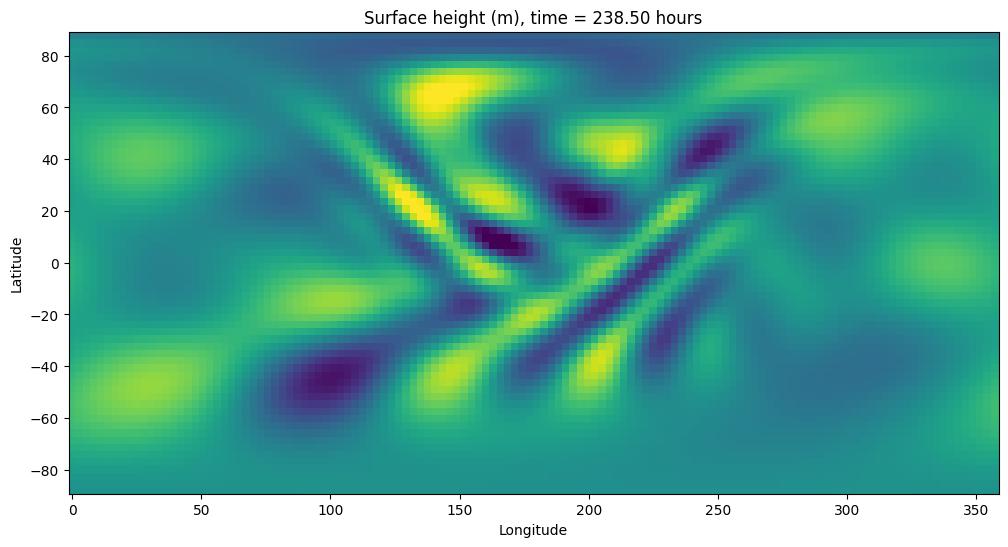

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

Text(0.5, 1.0, 'Virtual tide gauge at (the closest grid point to) $45^{\\circ}$N, $90^{\\circ}$W')

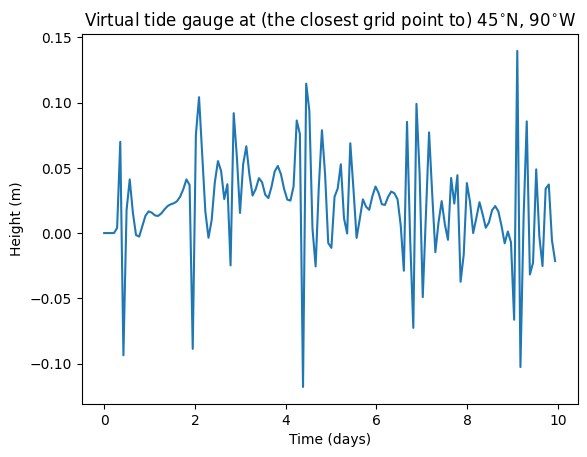

In [ ]:
# This script produces a virtual tide gauge by sampling the height at a latitude of 45degN and longitude of 90degW
phi_sample = np.pi/2
theta_sample = np.pi/4

phi_index = np.argmin(np.abs(phi - phi_sample))
theta_index = np.argmin(np.abs(theta - theta_sample))

h_sample = h_save[:,phi_index,theta_index]

plt.plot(t_save/(1*day),h_sample)
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.title('Virtual tide gauge at (the closest grid point to) $45^{\circ}$N, $90^{\circ}$W')

ADD PLOTS AND DISCUSSION HERE

The plot above shows the timeseries of the surface height at the point at a latitude of 45ºN and longitude of 90ºW.

In our simulation, we observe that as the gravity waves propagate around the Earth, their shape changes over time. However, by setting the angular velocity of the Earth, $\Omega$, to zero, we see that the wave no longer deforms. Instead, it oscillates symmetrically back and forth between opposite sides of the Earth, maintaining its shape. This suggests that the Coriolis force, which arises in the rotating reference frame, is the primary physical mechanism responsible for the evolution of the wave's shape.

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [ ]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians
tau = 0.1*day # Damping timescale

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)
f_phi = dist.Field(name='f_phi', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Damping term
f_phi['g'] = (1/2)*(1+np.tanh((phi-(3/2)*np.pi)/((1/10)*np.pi)))+(1/2)*(1-np.tanh((phi-(1/2)*np.pi)/((1/10)*np.pi)))

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) - (1/tau)*f_phi*h")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)
t_save = np.array(t_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


2024-12-19 20:32:24,426 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.4e+01/s


2024-12-19 20:32:24,531 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


2024-12-19 20:32:24,664 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


2024-12-19 20:32:24,795 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.3e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


2024-12-19 20:32:24,925 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.2e+01/s


2024-12-19 20:32:25,081 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 5.2e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 4.8e+01/s


2024-12-19 20:32:25,277 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 4.8e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


2024-12-19 20:32:25,459 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 4.5e+01/s


2024-12-19 20:32:25,641 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 4.5e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.4e+01/s


2024-12-19 20:32:25,842 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.4e+01/s


INFO:__main__:Starting main loop


2024-12-19 20:32:25,857 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2024-12-19 20:32:31,080 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2024-12-19 20:32:32,070 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2024-12-19 20:32:32,688 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2024-12-19 20:32:33,323 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2024-12-19 20:32:33,935 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2024-12-19 20:32:34,543 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2024-12-19 20:32:35,169 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2024-12-19 20:32:35,777 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2024-12-19 20:32:36,394 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2024-12-19 20:32:36,994 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2024-12-19 20:32:37,609 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2024-12-19 20:32:38,243 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2024-12-19 20:32:39,051 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2024-12-19 20:32:39,987 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2024-12-19 20:32:40,886 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2024-12-19 20:32:41,862 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2024-12-19 20:32:42,634 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2024-12-19 20:32:43,255 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2024-12-19 20:32:43,864 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2024-12-19 20:32:44,481 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2024-12-19 20:32:45,113 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2024-12-19 20:32:45,723 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2024-12-19 20:32:46,321 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2024-12-19 20:32:46,917 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2024-12-19 20:32:47,522 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2024-12-19 20:32:48,141 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2024-12-19 20:32:48,757 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2024-12-19 20:32:49,399 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2024-12-19 20:32:50,018 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2024-12-19 20:32:50,613 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2024-12-19 20:32:51,249 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2024-12-19 20:32:51,883 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2024-12-19 20:32:52,586 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2024-12-19 20:32:53,550 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2024-12-19 20:32:54,437 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2024-12-19 20:32:55,360 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2024-12-19 20:32:56,150 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2024-12-19 20:32:56,739 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2024-12-19 20:32:57,345 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2024-12-19 20:32:57,946 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2024-12-19 20:32:58,560 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2024-12-19 20:32:59,160 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2024-12-19 20:32:59,768 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2024-12-19 20:33:00,395 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2024-12-19 20:33:00,996 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2024-12-19 20:33:01,610 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2024-12-19 20:33:02,228 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2024-12-19 20:33:02,902 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2024-12-19 20:33:03,543 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2024-12-19 20:33:04,159 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2024-12-19 20:33:04,743 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2024-12-19 20:33:05,366 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2024-12-19 20:33:06,034 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2024-12-19 20:33:07,034 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2024-12-19 20:33:07,900 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2024-12-19 20:33:08,852 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2024-12-19 20:33:09,715 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2024-12-19 20:33:10,312 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2024-12-19 20:33:10,940 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2024-12-19 20:33:11,580 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2024-12-19 20:33:12,202 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2024-12-19 20:33:12,822 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2024-12-19 20:33:13,416 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2024-12-19 20:33:14,029 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2024-12-19 20:33:14,647 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2024-12-19 20:33:15,273 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2024-12-19 20:33:15,947 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2024-12-19 20:33:16,741 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2024-12-19 20:33:17,412 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2024-12-19 20:33:18,019 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2024-12-19 20:33:18,626 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2024-12-19 20:33:19,241 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2024-12-19 20:33:20,023 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2024-12-19 20:33:20,980 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2024-12-19 20:33:21,912 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2024-12-19 20:33:22,850 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2024-12-19 20:33:23,639 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2024-12-19 20:33:24,286 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2024-12-19 20:33:24,910 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2024-12-19 20:33:25,549 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2024-12-19 20:33:26,186 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2024-12-19 20:33:26,779 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2024-12-19 20:33:27,384 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2024-12-19 20:33:27,982 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2024-12-19 20:33:28,588 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2024-12-19 20:33:29,190 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2024-12-19 20:33:29,782 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2024-12-19 20:33:30,387 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2024-12-19 20:33:30,982 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2024-12-19 20:33:31,621 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2024-12-19 20:33:32,241 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2024-12-19 20:33:32,857 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2024-12-19 20:33:33,531 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2024-12-19 20:33:34,432 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2024-12-19 20:33:35,362 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2024-12-19 20:33:36,295 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2024-12-19 20:33:37,118 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2024-12-19 20:33:37,777 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2024-12-19 20:33:38,384 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2024-12-19 20:33:38,988 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2024-12-19 20:33:39,605 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2024-12-19 20:33:40,211 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2024-12-19 20:33:40,830 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2024-12-19 20:33:41,446 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2024-12-19 20:33:42,105 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2024-12-19 20:33:42,741 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2024-12-19 20:33:43,341 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2024-12-19 20:33:43,968 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2024-12-19 20:33:44,584 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2024-12-19 20:33:45,228 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2024-12-19 20:33:45,857 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2024-12-19 20:33:46,459 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2024-12-19 20:33:47,173 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2024-12-19 20:33:48,099 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2024-12-19 20:33:49,030 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2024-12-19 20:33:49,966 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2024-12-19 20:33:50,712 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2024-12-19 20:33:51,324 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2024-12-19 20:33:51,911 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2024-12-19 20:33:52,535 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2024-12-19 20:33:53,179 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2024-12-19 20:33:53,773 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2024-12-19 20:33:54,378 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2024-12-19 20:33:54,963 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2024-12-19 20:33:55,575 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2024-12-19 20:33:56,414 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2024-12-19 20:33:57,293 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2024-12-19 20:33:58,190 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2024-12-19 20:33:59,144 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2024-12-19 20:33:59,789 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2024-12-19 20:34:00,404 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2024-12-19 20:34:01,340 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2024-12-19 20:34:02,206 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2024-12-19 20:34:03,142 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2024-12-19 20:34:03,999 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2024-12-19 20:34:04,617 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2024-12-19 20:34:05,251 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2024-12-19 20:34:05,856 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2024-12-19 20:34:06,462 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2024-12-19 20:34:07,066 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2024-12-19 20:34:07,671 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2024-12-19 20:34:08,288 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2024-12-19 20:34:08,888 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2024-12-19 20:34:09,483 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2024-12-19 20:34:10,031 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-12-19 20:34:10,037 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-12-19 20:34:10,043 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 5.809 sec


2024-12-19 20:34:10,046 solvers 0/1 INFO :: Setup time (init - iter 0): 5.809 sec


INFO:solvers:Warmup time (iter 0-10): 1.848 sec


2024-12-19 20:34:10,050 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.848 sec


INFO:solvers:Run time (iter 10-end): 98.02 sec


2024-12-19 20:34:10,053 solvers 0/1 INFO :: Run time (iter 10-end): 98.02 sec


INFO:solvers:CPU time (iter 10-end): 0.02723 cpu-hr


2024-12-19 20:34:10,056 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02723 cpu-hr


INFO:solvers:Speed: 3.528e+05 mode-stages/cpu-sec


2024-12-19 20:34:10,058 solvers 0/1 INFO :: Speed: 3.528e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 20:38:58,335 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_09p2zvh/temp.m4v


2024-12-19 20:38:58,346 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_09p2zvh/temp.m4v


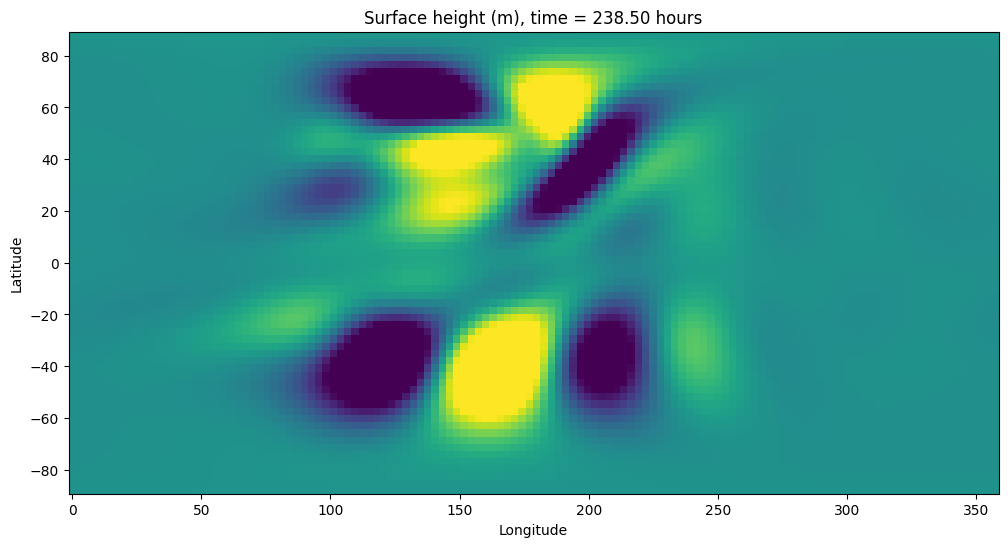

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.01, vmax=0.01)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

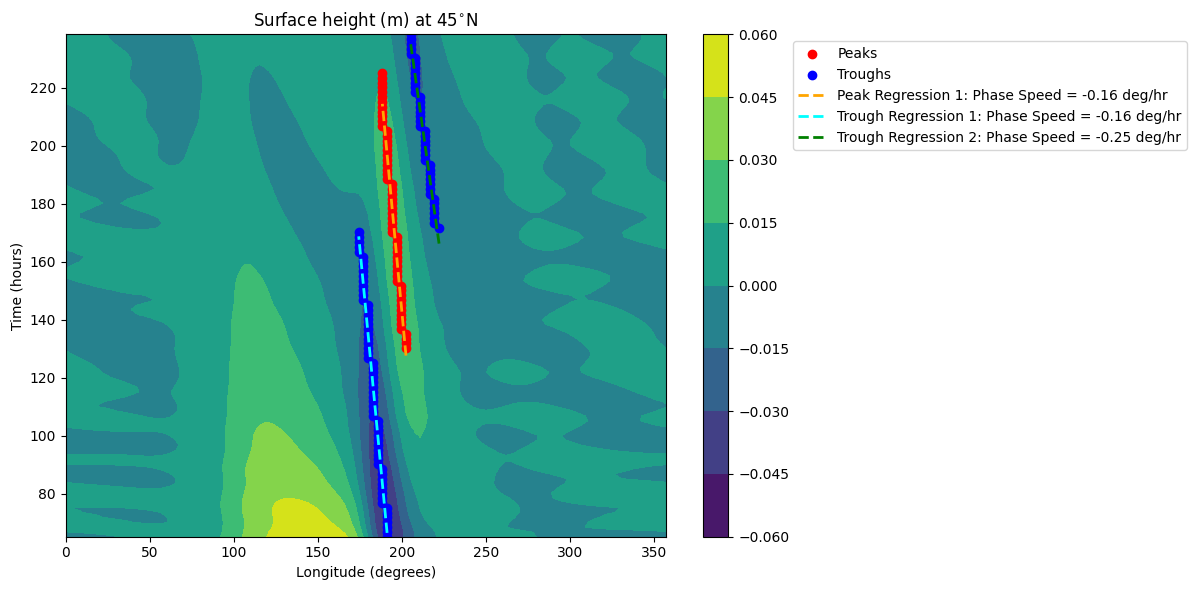

In [ ]:
# Plot the height as a function of longitude and time for latitide of 45deg
theta_sample = (1/4)*np.pi
theta_index = np.argmin(np.abs(theta - theta_sample))

longitude = phi[:,0]*360/(2*np.pi);

start_time = 65 * hour # let initial disturbance die down
start_time_index = np.argmin(np.abs(t_save - start_time))
time = t_save[start_time_index:]

h_longitude_time = np.zeros((len(time),len(longitude)))
for i in range(len(time)):
  h_longitude_time[i,:] = h_save[i+start_time_index,:,theta_index]

plt.figure(figsize=(12, 6))
plt.contourf(longitude,time/(1*hour),h_longitude_time)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Time (hours)')
plt.title('Surface height (m) at $45^{\circ}$N')
plt.colorbar()

peak_index_start = 39
peak_index_end = 97

peak_longitude=np.zeros(97-39)
for i in range(39,97):
  peak_index = np.argmax(h_longitude_time[i,:])
  peak_longitude[i-39] = longitude[peak_index]

trough_longitude = np.zeros(len(time))
for i in range(len(time)):
  trough_index = np.argmin(h_longitude_time[i,:])
  trough_longitude[i] = longitude[trough_index]
  if np.abs(trough_longitude[i] - trough_longitude[i-1]) > 10:
    trough_switch = i


plt.scatter(peak_longitude,time[39:97]/(1*hour),color='red', label = 'Peaks')
plt.scatter(trough_longitude,time/(1*hour),color='blue', label = 'Troughs')

peak1_slope, peak1_intercept = np.polyfit(peak_longitude, time[39:97]/(1*hour), 1)
peak1_line = peak1_slope * peak_longitude + peak1_intercept

trough1_slope, trough1_intercept = np.polyfit(trough_longitude[0:trough_switch-1], time[0:trough_switch-1]/(1*hour), 1)
trough1_line = trough1_slope * trough_longitude[0:trough_switch-1] + trough1_intercept

trough2_slope, trough2_intercept = np.polyfit(trough_longitude[trough_switch:], time[trough_switch:]/(1*hour), 1)
trough2_line = trough2_slope * trough_longitude[trough_switch:] + trough2_intercept


plt.plot(peak_longitude, peak1_line, color='orange', linestyle='--', linewidth=2, label=f'Peak Regression 1: Phase Speed = {1/peak1_slope:.2f} deg/hr')
plt.plot(trough_longitude[0:trough_switch-1], trough1_line, color='cyan', linestyle='--', linewidth=2, label=f'Trough Regression 1: Phase Speed = {1/trough1_slope:.2f} deg/hr')
plt.plot(trough_longitude[trough_switch:], trough2_line, color='green', linestyle='--', linewidth=2, label=f'Trough Regression 2: Phase Speed = {1/trough2_slope:.2f} deg/hr')


# Add a legend to the plot, positioning it outside the plot
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left')

# Adjust layout to make space for the legend
plt.tight_layout()





The first two code blocks above are copies of the dedalus script provided, but with the additional damping term added. After the initial tsunami disturbance decays, we can see shallow water Rossby waves in the Northern Hemisphere.

Balancing the Coriolis force with the pressure gradient (geostrophic balance), we expect the phase speed to scale like
$$ c \sim \frac{gh}{fL} \sim \frac{10\times1}{10^{-4}\times10^6} \sim 0.1\ \mathrm{m/s}$$


To determine the phase speed of the observed Rossby waves, we first plot the surface height at $45^{\circ}$N as a function of longitude and time, which is shown above. We then track the longitude of the maximum and minimum surface height at each time step, which are shown as red and blue points on the figure. Performing a linear regression for each set of points, we have several estimates for the phase speed. The average of these three calculated phase speeds is
\begin{align}
c_{\mathrm{output}} &\approx 0.19\  \mathrm{deg/hour} \\
&\approx \frac{0.19}{360}\times\frac{1}{\sqrt{2}}\times (2\pi \times 6378 \times 10^3)/3600 \approx 4\ \mathrm{m/s}
\end{align}

The Rossby waves in the Northern Hemisphere appear to be moving Westward, which is as we expect. We observe higher phase speeds than predicted.

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?